# Neural networks

## MLP Regressor

In [1]:
# Bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.datasets import co2


In [2]:

# Dados e Features
data = co2.load_pandas().data.dropna()
co2_vals = data['co2'].values

def create_features(data, n_lags=12):
    return np.array([data[i-n_lags:i] for i in range(n_lags, len(data))]), data[n_lags:]

X, y = create_features(co2_vals)


In [3]:

# Treinar a MLP
split = int(0.8 * len(X)) # 80% de treino e 20% de teste
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]


In [4]:

# Escalonamento dos dados
scaler_X, scaler_y = StandardScaler(), StandardScaler()


In [5]:

# Inicialização e treinamento da MLP
mlp = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=500, random_state=42)
mlp.fit(scaler_X.fit_transform(X_train), scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel())


,loss,'squared_error'
,hidden_layer_sizes,"(50, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500
,shuffle,True


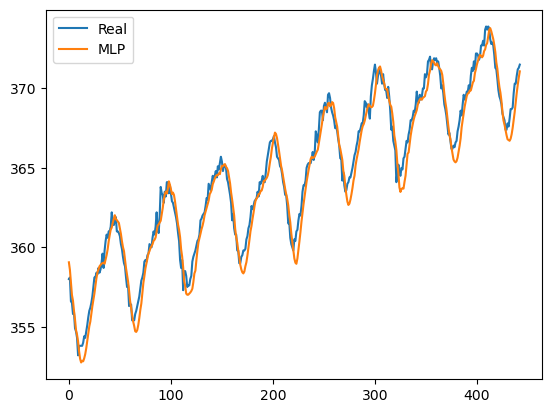

Erro: 0.69


In [6]:

# Prever e Plotar
y_pred = scaler_y.inverse_transform(mlp.predict(scaler_X.transform(X_test)).reshape(-1, 1)).ravel()

plt.plot(y_test, label='Real')
plt.plot(y_pred, label='MLP')
plt.legend()
plt.show()

print(f"Erro: {np.mean(np.abs(y_test - y_pred)):.2f}")

## LSTM

In [1]:
# Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.datasets import co2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam


In [2]:

# Carregar e preparar dados
data = co2.load_pandas().data
data = data.resample('ME').mean().ffill()


In [3]:

# Normalização
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.values)


In [4]:

# Parâmetros consistentes
LOOK_BACK = 12  # Janela histórica
HORIZON = 24  # Passos à frente para prever
EPOCHS = 100
BATCH_SIZE = 32

In [9]:
# Preparar dados para LSTM
def create_dataset(serie, look_back=12, forecast_horizon=12):
    X, y = [], []
    for i in range(len(serie)-look_back-forecast_horizon):
        X.append(serie[i:i+look_back])
        y.append(serie[i+look_back:i+look_back+forecast_horizon])
    return np.array(X), np.array(y)


In [11]:
X, y = create_dataset(data_scaled.flatten(), look_back=LOOK_BACK, forecast_horizon=HORIZON)
X = X.reshape(X.shape[0], X.shape[1], 1) # Reformatar para LSTM

In [12]:

# Modelo LSTM
model = Sequential([
    # Camada LSTM com return_sequences=True para empilhar LSTMs
    LSTM(64, activation='tanh', input_shape=(LOOK_BACK, 1)),
    BatchNormalization(),
    Dropout(0.2), # Regularização
    
    # Camada densa adicional
    Dense(32, activation='relu'),
    
    # Camada de saída
    Dense(HORIZON)
])

2025-11-30 19:21:21.705116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-11-30 19:21:21.705954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-11-30 19:21:21.706442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [13]:
# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


In [14]:

# Treinamento
history = model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
print(f"Menor Loss de Treino: {np.min(history.history['loss']):.4f}")


2025-11-30 19:21:49.400161: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-11-30 19:21:49.535167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-11-30 19:21:49.535664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-11-30 19:21:49.536204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG IN

Menor Loss de Treino: 0.0028


In [15]:

# Previsão
last_window = data_scaled[-LOOK_BACK:].reshape(1, LOOK_BACK, 1)
forecast = model.predict(last_window)
forecast = scaler.inverse_transform(forecast.reshape(-1, 1))


1/1 [==============================] - 0s 185ms/step


2025-11-30 19:21:54.031691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-11-30 19:21:54.032243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-11-30 19:21:54.033369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

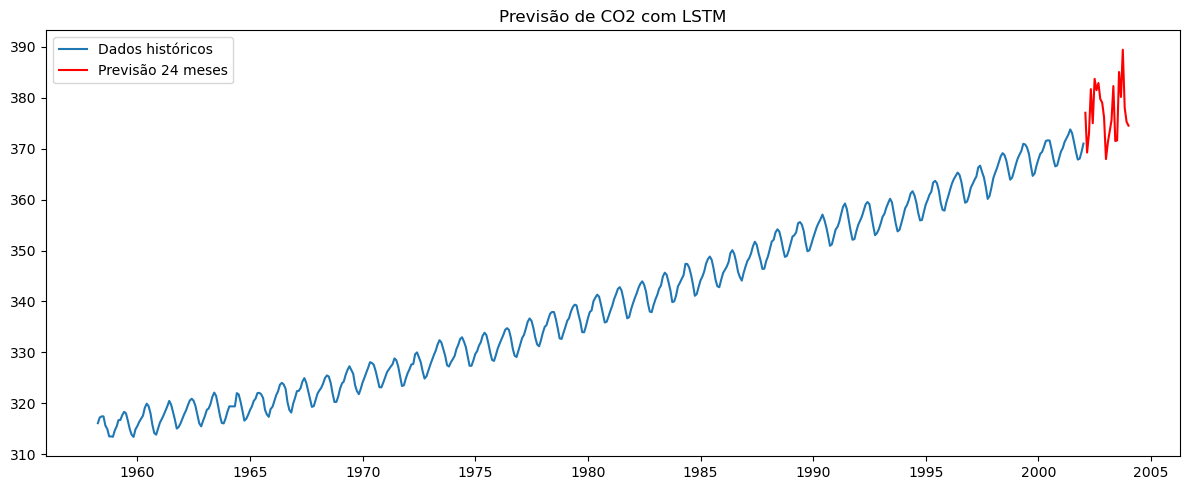

In [16]:

# Plot
plt.figure(figsize=(12, 5))
plt.plot(data.index, data.values, label='Dados históricos')
future_dates = pd.date_range(data.index[-1], periods=HORIZON+1, freq='ME')[1:]
plt.plot(future_dates, forecast, 'r', label=f'Previsão {HORIZON} meses')
plt.title('Previsão de CO2 com LSTM')
plt.legend()
plt.tight_layout()
plt.show()